In [68]:
sd = 123 # Here sd means seed.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf

from datetime import date

from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import importlib
import scripts.LstmStrategy as sl

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras import layers,Sequential
from tensorflow.keras.layers import LSTM,RepeatVector,TimeDistributed,Dense,Dropout
from keras.callbacks import EarlyStopping
%load_ext autoreload
%autoreload 2
#importlib.reload(ss) #above magic works so won't need to manual reload
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16, 6)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import tensorflow as tf
import numpy as np
import random as rn


np.random.seed(sd)
rn.seed(sd)
os.environ['PYTHONHASHSEED']=str(sd)

from keras import backend as K
tf.random.set_seed(sd)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [69]:
#data prepare
start=date(1990, 1, 1)
end=date(2020, 11, 16)

stock_list=['ICE', 'WLTW']
stock_pair=yf.download(stock_list, start, end, progress = False)

stock_pair=stock_pair[['Adj Close']].copy()
stock_pair.dropna(how='any', axis=0, inplace=True)
stock_pair.columns=stock_pair.columns.droplevel()
stock_pair.index=pd.DatetimeIndex(stock_pair.index)
#stock_pair.head()
dog_leash=stock_pair.copy()
smoothing='yes'
if smoothing=='yes':
        dog_leash=dog_leash.rolling(window=5).mean()
        dog_leash.dropna(inplace=True)
c=np.polyfit(dog_leash.iloc[:, 0], dog_leash.iloc[:, 1], 1)
dog_leash['Dog_leash']=dog_leash.iloc[:, 1]-c[0]*dog_leash.iloc[:, 0]
dog_leash=dog_leash[['Dog_leash']]
test_data=pd.merge(stock_pair, dog_leash, how='outer', on='Date')
test_data.dropna(how='any', axis=0, inplace=True)
test_data=test_data.reset_index()
test_data['realcombo']=-test_data.iloc[:,1]*c[0]+test_data.iloc[:,2]
test_data['realcombo_before_std']=test_data.realcombo
#standard
realcombo_mean=test_data.realcombo.mean()
realcombo_std=test_data.realcombo.std()
test_data.realcombo=(test_data.realcombo-test_data.realcombo.mean())/test_data.realcombo.std()


In [70]:
test_data

,Date,ICE,WLTW,Dog_leash,realcombo,realcombo_before_std
0,2005-11-22,6.342704,69.851379,58.752772,2.643456,59.340512
1,2005-11-23,6.161225,69.651382,59.311547,2.655225,59.441256
2,2005-11-25,6.197519,69.724091,59.515885,2.656692,59.453819
3,2005-11-28,6.043263,68.378700,59.294517,2.529390,58.364055
4,2005-11-29,5.801895,67.324211,58.861839,2.452934,57.709551
...,...,...,...,...,...,...
3766,2020-11-09,98.220001,196.000000,24.116557,-0.406221,33.233881
3767,2020-11-10,98.000000,202.009995,27.773579,0.338432,39.608453
3768,2020-11-11,99.980003,202.949997,30.976658,0.064945,37.267276
3769,2020-11-12,98.309998,202.199997,34.950952,0.300618,39.284740


In [ ]:
trendpredict=[]
count=-1

for i in range(2500,3372):
    count=count+1
    if count%100==0:
        print(f'completed 100. on iteration {i}')
    future=build_model_and_predict(test_data,i,i+200,7)
    trend=sl.trendHelper(future)
    trendpredict.append([i+200,trend])
    #print(f'at idx {i+200} predicted trend is: {trend}')
    
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
print(profit_cumulative)

completed 100. on iteration 2500
completed 100. on iteration 2600
completed 100. on iteration 2700


In [73]:
trend_prediction=pd.DataFrame(trendpredict, columns=('day_index', 'trend_predict'))
trend_prediction.to_csv('./data/lstmmodel_trend_predict_2500_3371.csv')
transaction_list_pd=pd.DataFrame(transaction_list,columns=('day_index','open_close','L/S','profit','trend_predicted'))
transaction_list_pd.to_csv('./data/lstmmodel_transaction_records_2500_3371.csv')

In [75]:
profit_cumulative,transaction_list=sl.trend_prediction_to_transaction(trendpredict,test_data)
print(profit_cumulative)

53.66957886259635


Epoch 00046: early stopping


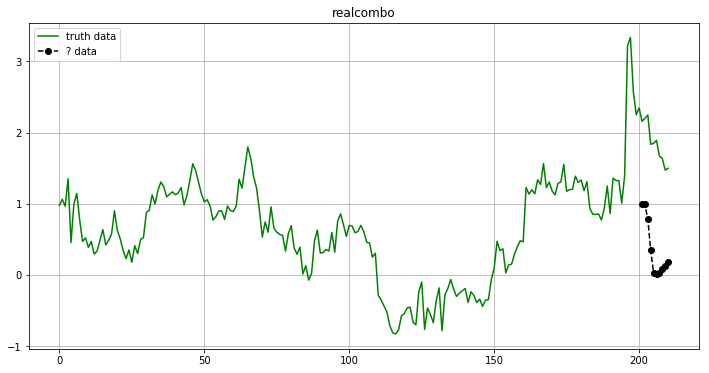

DOWN1


In [1080]:
starting_point=3576-200
future=build_model_and_predict_and_show(test_data,starting_point,starting_point+200,7)
print(sl.trendHelper(future))

In [47]:
#predict future
def build_model_and_predict(test_data,START=0,END=START+200,look_back=7,future_size=10,select_col='realcombo'):
    
    dataset=test_data.loc[START:END,select_col].to_numpy()
    dataset=np.nan_to_num(dataset)
    dataset=np.reshape(dataset,(dataset.shape[0],1,1))
    x,y=sl.create_dataset(dataset[:],look_back)
    x=np.reshape(x,(x.shape[0],1,x.shape[1]))
    y=np.reshape(y,(y.shape[0],y.shape[1]))

    size=len(x)
       
    model=sl.build_model(look_back,sd)
    #model.summary()
    # simple early stopping
    es = EarlyStopping(monitor='loss', patience=5, verbose=0)
    model.compile(optimizer='adam',loss='mse',metrics=['acc'])
    model.fit(x,y,epochs=150,callbacks=[es],verbose=0)


    future=[]
    latest_data=dataset.ravel()
    latest_data=latest_data[-look_back:]
    next_pred=model.predict(latest_data.reshape(-1,1,look_back))
    future.append(next_pred[0][0])
    while len(future)<future_size:
        latest_data=latest_data[-look_back+1:]
        latest_data=np.append(latest_data,next_pred)
        next_pred=model.predict(latest_data.reshape(-1,1,look_back))
        future.append(next_pred[0][0])

    return future
    # shift future predictions for plotting
    #futurePredictPlot = np.zeros((dataset.shape[0]+future_size,))
    #futurePredictPlot[:] = np.nan
    #futurePredictPlot[dataset.shape[0]:dataset.shape[0]+future_size] = future[:]
    
    # plot baseline and predictions
    #true_data, = plt.plot(df.loc[START:END+future_size,select_col].to_numpy(),color='g', label='truth data')
    #future_data, = plt.plot(futurePredictPlot,color='k',marker='o',linestyle='dashed', label='? data')
    #plt.legend(handles = [true_data,future_data])
    #plt.title(select_col)
    #plt.grid()
    #plt.show()
    

In [65]:
#predict future and show graph
START=0
def build_model_and_predict_and_show(test_data,START,END,look_back=7,future_size=10,select_col='realcombo'):
    
    dataset=test_data.loc[START:END,select_col].to_numpy()
    dataset=np.nan_to_num(dataset)
    #print(dataset.shape) ##NOTE: END IS INCLUDED
    dataset=np.reshape(dataset,(dataset.shape[0],1,1))
    x,y=sl.create_dataset(dataset[:],look_back)
    x=np.reshape(x,(x.shape[0],1,x.shape[1]))
    y=np.reshape(y,(y.shape[0],y.shape[1]))

    size=len(x)
       
    model=sl.build_model(look_back,sd)
    #model.summary()
    # simple early stopping
    es = EarlyStopping(monitor='loss', patience=5, verbose=1)
    model.compile(optimizer='adam',loss='mse',metrics=['acc'])
    model.fit(x,y,epochs=150,callbacks=[es],verbose=0)


    future=[]
    latest_data=dataset.ravel()
    latest_data=latest_data[-look_back:]
    next_pred=model.predict(latest_data.reshape(-1,1,look_back))
    future.append(next_pred[0][0])
    while len(future)<future_size:
        latest_data=latest_data[-look_back+1:]
        latest_data=np.append(latest_data,next_pred)
        next_pred=model.predict(latest_data.reshape(-1,1,look_back))
        future.append(next_pred[0][0])


    # shift future predictions for plotting
    futurePredictPlot = np.zeros((dataset.shape[0]+future_size,))
    futurePredictPlot[:] = np.nan
    futurePredictPlot[dataset.shape[0]:dataset.shape[0]+future_size] = future[:]
    
    # plot baseline and predictions
    true_data, = plt.plot(test_data.loc[START:END+future_size,select_col].to_numpy(),color='g', label='truth data')
    future_data, = plt.plot(futurePredictPlot,color='k',marker='o',linestyle='dashed', label='? data')
    plt.legend(handles = [true_data,future_data])
    plt.title(select_col)
    plt.grid()
    plt.show()
    return future

(201,)
Epoch 00060: early stopping


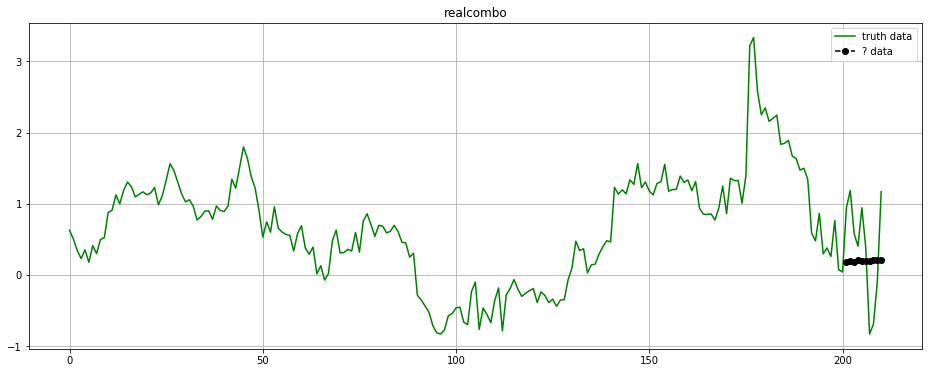

-


In [64]:
f=build_model_and_predict_and_show(test_data,3396,3596,7)
print(sl.trendHelper(f))

[0.005027473, 0.010704726, 0.02560684, 0.050698668, 0.14018783, 0.29755408, 0.41545448, 0.29751527, 0.2739182, 0.25600427]
[0, 0, 0, 0.6343597, 1.1155185, 0.83575785, -0.8360329, 0, 0]
[0, 0, 1.1572960656129, 0.8778033879127936, -0.5103820936751522, -3.049936554402586, 1.5252191945520441, 0]


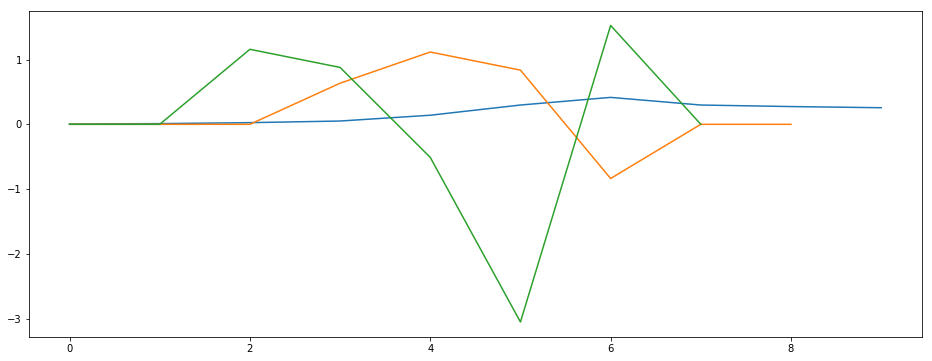

0.410427
UP


In [44]:
future_diff1=sl.differentialHelper(future)
future_diff2=sl.differentialHelper(future_diff1)
print(future)
print(future_diff1)
print(future_diff2)
plt.plot(future)
plt.plot(future_diff1)
plt.plot(future_diff2)
plt.show()
print(sl.trendHelper(future))

In [66]:
trend_prediction=pd.read_csv('./data/lstmmodel_trend_predict_200.csv')
trend_prediction=trend_prediction.iloc[:,1:]
trend_prediction['day_index']=trend_prediction['day_index']+200

In [67]:
trend_prediction

,day_index,trend_predict
0,3570,-
1,3571,-
2,3572,-
3,3573,-
4,3574,-
...,...,...
196,3766,UP1
197,3767,UP0
198,3768,UP0
199,3769,UP0
